In [14]:
import numpy as np
import pandas as pd
import torch
import json
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import scipy

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn.cluster import KMeans

import seaborn as sns

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [9]:
 with open("core_parts.json", "r") as f:
    core_parts = json.load(f)

In [5]:
ds_pandas = pd.read_excel("input.xlsx", sheet_name="no_burnup")

In [6]:
ds_pandas

Name     7-6_s     7-5_s     7-4_s     7-3_s     6-6_s  \
0      121_random_0  1.043046  1.037114  1.117677  1.023991  0.945399   
1      121_random_1  0.509661  0.808204  0.892903  1.134111  0.669460   
2      121_random_2  0.993596  0.983636  0.958598  0.823306  0.993841   
3      121_random_3  0.842348  0.988370  1.126815  0.951305  1.082704   
4      121_random_4  0.747439  0.913736  1.030984  0.930395  0.760627   
..              ...       ...       ...       ...       ...       ...   
542  121_random_544  0.670246  0.857544  0.785604  1.072925  0.907801   
543  121_random_545  0.720889  0.731125  0.802561  1.156266  0.750501   
544  121_random_546  1.028954  1.033075  0.872344  1.100162  0.981495   
545  121_random_547  0.594511  1.025157  1.022720  1.014120  1.013433   
546  121_random_548  0.896351  0.938825  1.180523  1.082421  1.162662   

        6-5_s     6-4_s     6-3_s     5-6_s  ...  4-3_t  3-6_t  3-5_t  3-4_t  \
0    1.227447  1.361819  0.940764  1.031618  ...    300    265    265    265   
1    1.168714  0.998008  1.052935  1.060237  ...    300    265    265    265   
2    1.095063  0.756411  1.167815  0.972785  ...    300    265    265    265   
3    1.171051  1.209545  1.304562  1.250154  ...    300    265    265    265   
4    1.163903  0.988270  1.025057  1.029310  ...    300    265    265    265   
..        ...       ...       ...       ...  ...    ...    ...    ...    ...   
542  0.995220  1.162036  1.052018  1.244894  ...    300    265    265    265   
543  1.269837  1.223177  1.110648  0.940493  ...    300    265    265    265   
544  1.286540  1.290679  0.997712  1.007821  ...    300    265    265    265   
545  1.271851  1.294391  1.046027  1.083255  ...    300    265    265    265   
546  1.156700  0.964028  0.912833  1.302882  ...    300    265    265    265   

     3-3_t  2-6_t  2-5_t  2-4_t  2-3_t     p_mar  
0      265    300    300    300    300  6.698140  
1      265    300    300    300    300  3.613529  
2      265    300    300    300    300  5.010686  
3      265    300    300    300    300  5.671946  
4      265    300    300    300    300  7.741418  
..     ...    ...    ...    ...    ...       ...  
542    265    300    300    300    300  8.025679  
543    265    300    300    300    300  7.449398  
544    265    300    300    300    300  6.174647  
545    265    300    300    300    300  7.445115  
546    265    300    300    300    300  0.769040  

[547 rows x 62 columns]

In [12]:
ds_pandas.columns

Index(['Name', '7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-6_s', '6-5_s', '6-4_s',
       '6-3_s', '5-6_s', '5-3_s', '4-6_s', '4-3_s', '3-6_s', '3-5_s', '3-4_s',
       '3-3_s', '2-6_s', '2-5_s', '2-4_s', '2-3_s', '7-6_b', '7-5_b', '7-4_b',
       '7-3_b', '6-6_b', '6-5_b', '6-4_b', '6-3_b', '5-6_b', '5-3_b', '4-6_b',
       '4-3_b', '3-6_b', '3-5_b', '3-4_b', '3-3_b', '2-6_b', '2-5_b', '2-4_b',
       '2-3_b', '7-6_t', '7-5_t', '7-4_t', '7-3_t', '6-6_t', '6-5_t', '6-4_t',
       '6-3_t', '5-6_t', '5-3_t', '4-6_t', '4-3_t', '3-6_t', '3-5_t', '3-4_t',
       '3-3_t', '2-6_t', '2-5_t', '2-4_t', '2-3_t', 'p_mar'],
      dtype='object')

In [1765]:
X = ds_pandas.loc[
    :, 
    [
        *core_parts["burnup"]["ALL_CELLS"],
        # *core_parts["fuel_type"]["ALL_CELLS"]
    ]
].to_numpy()
X = MinMaxScaler(feature_range=(0.5,1.5)).fit_transform(X)
# X = MinMaxScaler().fit_transform(X)
# X = StandardScaler().fit_transform(X)

(array([1., 1., 1., 3., 2., 4., 4., 2., 1., 1.]),
 array([0.62889078, 0.70745131, 0.78601184, 0.86457238, 0.94313291,
        1.02169344, 1.10025398, 1.17881451, 1.25737505, 1.33593558,
        1.41449611]),
 <BarContainer object of 10 artists>)

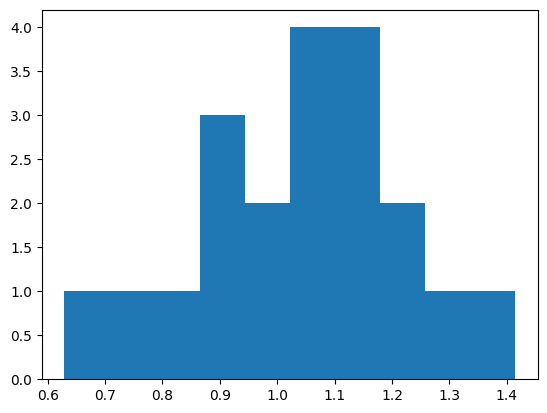

In [1766]:
plt.hist(
    X[1, :]
)

In [1767]:
y = ds_pandas.loc[:, core_parts["coef"]["ALL_CELLS"]].to_numpy()
y = MinMaxScaler(feature_range=(0.5,1.5)).fit_transform(y)
# y = StandardScaler().fit_transform(y)

In [1768]:
y.shape

(547, 20)

In [1769]:
mvd1 = np.random.multivariate_normal(
    y[:200].mean(axis=1),
    np.cov(y[:200])
)
mvd2 = np.random.multivariate_normal(
    y[200:400].mean(axis=1),
    np.cov(y[200:400])
)

(array([ 1.,  1., 11., 37., 39., 49., 35., 19.,  5.,  3.]),
 array([0.59528989, 0.69004517, 0.78480045, 0.87955573, 0.974311  ,
        1.06906628, 1.16382156, 1.25857684, 1.35333212, 1.44808739,
        1.54284267]),
 <BarContainer object of 10 artists>)

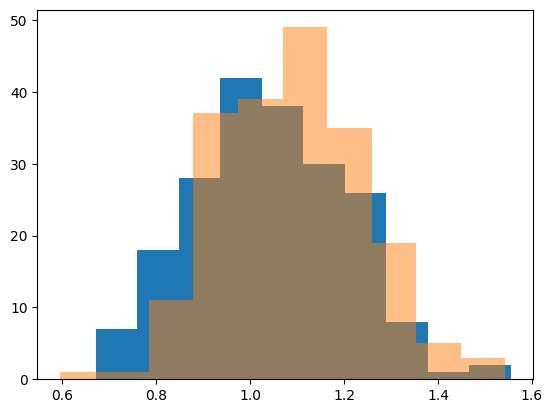

In [1770]:
plt.hist(mvd1)
plt.hist(mvd2, alpha=0.5)

In [1771]:
mvd1 = torch.from_numpy(mvd1)
mvd2 = torch.from_numpy(mvd2)

In [1772]:
import torch.nn.functional as F

In [1773]:
F.kl_div(mvd1, mvd2)

/home/mrzlka/.pyenv/versions/3.10.0/envs/dl_3.10.0/lib/python3.10/site-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor(-1.0322, dtype=torch.float64)

In [1774]:
yt = torch.from_numpy(y) 

In [1775]:
yt1 = yt[:200]
yt2 = yt[200:400]

In [1776]:
mean_yt1 = yt1.mean(dim=1)
mean_yt2 = yt2.mean(dim=1)

In [1777]:
mean_yt1.shape

torch.Size([200])

In [1778]:
std_yt1 = yt1.std(dim=1)
std_yt2 = yt2.std(dim=1)

In [1779]:
std_yt1_tril = torch.diag_embed(std_yt1)
std_yt2_tril = torch.diag_embed(std_yt2)


In [1780]:
yt1_sample = torch.distributions.MultivariateNormal(
    mean_yt1,
    scale_tril=std_yt1_tril
).rsample()
yt2_sample = torch.distributions.MultivariateNormal(
    mean_yt2,
    scale_tril=std_yt2_tril
).rsample()

In [1781]:
yt1_sample.shape

torch.Size([200])

(array([ 5.,  4., 13., 21., 31., 53., 33., 23., 12.,  5.]),
 array([0.62299031, 0.70925788, 0.79552545, 0.88179302, 0.96806059,
        1.05432816, 1.14059573, 1.2268633 , 1.31313087, 1.39939844,
        1.48566601]),
 <BarContainer object of 10 artists>)

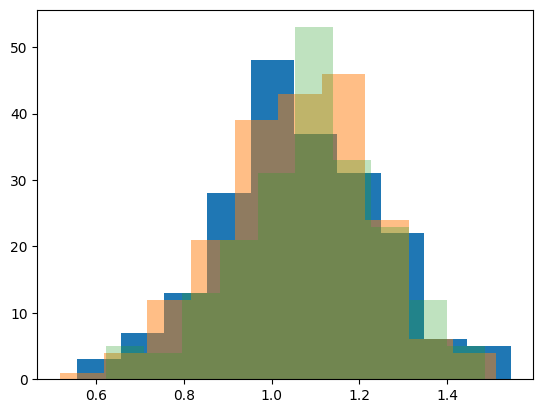

In [1782]:
plt.hist(yt1_sample.numpy())
plt.hist(yt2_sample.numpy(), alpha=0.5)
plt.hist(yt1[:,0].numpy(), alpha=0.3)


In [1784]:
F.kl_div(yt1_sample, yt2_sample), F.kl_div(yt1[:,2], yt2_sample)

(tensor(-1.0518, dtype=torch.float64), tensor(-0.9872, dtype=torch.float64))

In [1785]:
size = len(X)
tr = int(0.8*size)

In [1786]:
y_tr = torch.from_numpy(y[:tr])
X_tr = torch.from_numpy(X[:tr])

In [1787]:
y_te = torch.from_numpy(y[tr:])
X_te = torch.from_numpy(X[tr:])

In [1788]:
y_tr = y_tr.type(torch.float)
X_tr = X_tr.type(torch.float)
y_te = y_te.type(torch.float)
X_te = X_te.type(torch.float)

In [1789]:
X_te

tensor([[0.9957, 0.5775, 1.2544,  ..., 0.8887, 0.8273, 1.0262],
        [0.9703, 0.9032, 0.8132,  ..., 0.8228, 0.7702, 0.7384],
        [0.7464, 0.9682, 0.9610,  ..., 1.0908, 0.7237, 0.7757],
        ...,
        [0.7431, 0.9070, 1.1890,  ..., 1.0308, 1.0256, 1.2003],
        [1.3482, 0.8370, 0.8907,  ..., 0.9819, 1.1492, 1.0459],
        [1.1318, 1.1742, 0.8391,  ..., 1.1666, 1.2378, 1.0151]])

In [1793]:
tr_td = TensorDataset(
    X_tr,
    y_tr
)
te_td = TensorDataset(
    X_te,
    y_te
)

In [1794]:
tr = DataLoader(
    tr_td,
    batch_size=32
)
te = DataLoader(
    te_td,
    batch_size=32
)

In [1795]:
# rows, cols
features = next(iter(tr))[0].shape[-1]
next(iter(tr))[0].shape

torch.Size([32, 20])

## Adoption VAE to predict heterogeneity of reactor core

In [2060]:
por = next(iter(tr))[0]
por = por.to(device)
por.shape

torch.Size([32, 20])

In [2206]:
### z1 - latent to get p(z|x)
### z2 - latent to get p(y|x)

class SSVAE(nn.Module):
    def __init__(
        self
    ):
        super().__init__()

        self.y_prior = 1  # N(0, I)
        
        # y encoder - predictor
        self.predictor = nn.Sequential(
            nn.Linear(20, 128),
            nn.ReLU(),
            nn.Linear(128, 20),
            nn.ReLU()
        )
        
        self.encoder = nn.Sequential(
            nn.Linear(20, 128)
        )
        
        self.z1_mu = nn.Linear(128, 20)
        self.z1_logvar = nn.Linear(128, 20)

        self.decoder = nn.Sequential(
            nn.Linear(20, 128),
            nn.ReLU(),
            nn.Linear(128, 20)
        )

    def reparametrize_z1(
        self,
        x
    ):
        mu = F.relu(
            self.z1_mu(x)
        )
        logvar = F.relu(
            self.z1_mu(x)
        )

        std = torch.exp(logvar/2)
        z = mu + std*torch.rand_like(std)
        
        return mu, logvar, z
        
    def forward(
        self,
        x,
        y
    ):
    
        y_hat = self.predictor(x)
        # print(torch.sum(cls, dim=1))
        # if y is not None:
        #     cls = self.y_onehot[y]
        # x = torch.cat(
        #     (x,z2),
        #     dim=-1
        # )
        if y is None:
            y = y_hat
        encoded = self.encoder(y)
        z1_mu, z1_logvar, z1 = self.reparametrize_z1(encoded)
        # z = torch.cat(
        #     (z1, z2),
        #     dim=-1
        # )
        decoded = self.decoder(z1)
        
        return decoded, y_hat, z1, z1_logvar, z1_mu


def supervised_loss(
    x,
    output,
    target,
    pred,
    logvar,
    mu,
    batch_size
):
    recon_loss = F.mse_loss(output, x, reduction='sum') / batch_size
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))

    # kly_loss = F.kl_div(pred, target, reduction="batchmean")
    yhat_loss = F.mse_loss(pred, target, reduction='sum') / batch_size
    # print(recon_loss, yhat_loss)
    
    return recon_loss + kl_loss + yhat_loss, recon_loss, kl_loss, yhat_loss

def unsupervised_loss(
    x,
    output,
    pred, # to calc entropy
    z1_logvar,
    z1_mu,
    z2_logvar,
    z2_mu,
    batch_size
):
    
    kly_loss = -0.5 * torch.sum(1 + z2_logvar - z2_mu.pow(2) - torch.exp(z2_logvar))

    kl_loss = -0.5 * torch.sum(1 + z1_logvar - z1_mu.pow(2) - torch.exp(z1_logvar))

    recon_loss = F.mse_loss(output, x, reduction='sum') / batch_size

    return recon_loss - kl_loss - kly_loss, recon_loss, kl_loss, kly_loss
    
    

In [2204]:
def train(
    model,
    dataset,
    optimizer
):
        epoch_loss  = 0
        for nbatch, (X,y) in enumerate(dataset):
            X = X.to(device)
            y = y.to(device)
            y_deep = torch.clone(y)
            
            if nbatch % 5 != 0:
                y = None
            
            # Zero the gradients
            optimizer.zero_grad()
            
            output, y_hat, z1, z1_logvar, z1_mu  = model(X,y)

            # print(z1.shape, y.shape)
            # if y is None:
            #     loss, rl, kll, kldcl = unsupervised_loss(
            #         X,
            #         output,
            #         z1,
            #         z1_logvar,
            #         z1_mu,
            #         z2_logvar,
            #         z2_mu,
            #         X.shape[0]
            #     )
            #     # print(rl, kll, kldcl)

            # else:
            
            
            loss, rl, kll, yhat_loss = supervised_loss(
                X,
                output,
                y_deep,
                y_hat,
                z1_logvar,
                z1_mu,
                X.shape[0]
            )
                
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
        print(f"loss per batch: {epoch_loss/len(X)}")


In [2205]:
def test(
    model,
    dataset,
    epoch_num,
    writer=None
):
    test_loss = 0.0
    cls_loss = 0.0
    
    with torch.no_grad():
        for nbatch, (X,y) in enumerate(dataset):
            X = X.to(device)
            y = y.to(device)
            y_deep = torch.clone(y)
            
            if nbatch % 5 != 0:
                y = None
                
            output, y_hat, z1, z1_logvar, z1_mu  = model(X,y)

            # if y is None:
                
            #     loss, rl, kll, kldcl = unsupervised_loss(
            #         X,
            #         output,
            #         z1,
            #         z1_logvar,
            #         z1_mu,
            #         z2_logvar,
            #         z2_mu,
            #         X.shape[0]
            #     )
            #     # print(kldcl)
            #     test_loss += loss.item()
            # else:
            
            
            loss, rl, kll, yhat_loss = supervised_loss(
                X,
                output,
                y_deep,
                y_hat,
                z1_logvar,
                z1_mu,
                X.shape[0]
            )
            test_loss += loss.item()

            # print(y_pred.argmax(1),y_deep)
            # cls_loss += (y_pred.argmax(1) == y_deep).type(torch.float).sum().item() / len(X)
            # print(cls_loss)

        if epoch_num % 2 == 0 and writer is not None:
            # print(y_hat, y_deep)
            writer.add_scalar('Test/y_Loss', yhat_loss, global_step=epoch_num)
            writer.add_scalar('Test/x_Loss', rl, global_step=epoch_num)
            
        test_loss = test_loss / len(dataset)
        # cls_loss = cls_loss / len(dataset)
        
        print(
            f"Test Error: \n Accuracy: Avg loss: {test_loss:>8f} \n",
            # f"Classification Test Error: \n Accuracy: {100*cls_loss:>8f}% \n"
        )

In [1068]:
model = SSVAE().to(device)

In [1069]:
writer = SummaryWriter(f'irt_het/test2')

In [1070]:
adam = torch.optim.Adam(model.parameters())

In [1071]:
epoch = 100
for e in range(epoch):
    train(
        model,
        tr,
        adam
    )
    
    z = test(
        model,
        te,
        e,
        writer
    )

loss per batch: 29.442823500860307
Test Error: 
 Accuracy: Avg loss: 42.242403 

loss per batch: 26.32636951264881
Test Error: 
 Accuracy: Avg loss: 40.136024 

loss per batch: 25.076404753185454
Test Error: 
 Accuracy: Avg loss: 38.402216 

loss per batch: 24.107337770007906
Test Error: 
 Accuracy: Avg loss: 37.052268 

loss per batch: 23.313250223795574
Test Error: 
 Accuracy: Avg loss: 35.933777 

loss per batch: 22.6219607761928
Test Error: 
 Accuracy: Avg loss: 34.921955 

loss per batch: 22.030449004400346
Test Error: 
 Accuracy: Avg loss: 34.133021 

loss per batch: 21.64632424854097
Test Error: 
 Accuracy: Avg loss: 33.714680 

loss per batch: 21.363763536725724
Test Error: 
 Accuracy: Avg loss: 33.404167 

loss per batch: 21.19161587669736
Test Error: 
 Accuracy: Avg loss: 33.071336 

loss per batch: 21.03938139052618
Test Error: 
 Accuracy: Avg loss: 33.005641 

loss per batch: 20.971580505371094
Test Error: 
 Accuracy: Avg loss: 32.805917 

loss per batch: 20.929829461233957

# Extra tests on MND

In [4042]:
### z1 - latent to get p(z|x)
### zy - latent to get p(y|x)

class SSVAE(nn.Module):
    def __init__(
        self
    ):
        super().__init__()

        self.y_prior = 1  # N(0, I)
        
        # y encoder - predictor
        self.predictor = nn.Sequential(
            nn.Linear(40, 128),
            nn.ReLU(),
            nn.Linear(128, 20),
            nn.Sigmoid()
        )
        
        self.encoder = nn.Sequential(
            nn.Linear(20+20, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
        )
        
        self.z_mu = nn.Linear(128, 20)
        self.z_logvar = nn.Linear(128, 20)

        self.decoder = nn.Sequential(
            nn.Linear(20+20, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 20),
            nn.Sigmoid()
        )

    def reparametrize_z(
        self,
        x
    ):
        mu = F.relu(
            self.z_mu(x)
        )
        logvar = F.relu(
            self.z_logvar(x)
        )

        std = torch.exp(logvar/2)
        z = mu + std*torch.rand_like(std)
        
        return mu, logvar, z

    def parametrize_y(
        self,
        x,
        standartize=False
    ):
        if standartize:
            means = x.mean(dim=0)
            stds = x.std(dim=0)
            x = (x - means) / stds
        
        mu_y = x.mean(dim=0)
        # mu_y = torch.zeros(len(x))
        # mu_y = mu_y.to(device)
        
        
        
        var_y = x.std(dim=0)
        var_tril_y = torch.diag_embed(var_y)

        samples = torch.distributions.MultivariateNormal(
            mu_y,
            scale_tril=var_tril_y
        ).sample(torch.Size([32]))
        # shape of batch
        return (
            samples,
            samples.mean(dim=0),
            samples.std(dim=0)
        )
        
    def forward(
        self,
        x,
        y
    ):
    
        x_vae = x[:, :20]
        y_hat = self.predictor(x)
        
        # print(torch.sum(cls, dim=1))
        # if y is not None:
        #     cls = self.y_onehot[y]
        if y is None:
            y = y_hat
        x = torch.cat(
            (x_vae,y),
            dim=-1
        )    
        encoded = self.encoder(x)
        z_mu, z_logvar, z = self.reparametrize_z(encoded)
        z = torch.cat(
            (z, y),
            dim=-1
        )
        decoded = self.decoder(z)
        
        return decoded, y_hat, z, z_logvar, z_mu


alpha = 0.01
def supervised_loss(
    x,
    output,
    target,
    pred,
    logvar,
    mu,
    batch_size
):
    x = torch.abs(x)
    output = torch.abs(output)

    pred = torch.abs(pred)
    target = torch.abs(target)
    
    recon_loss = alpha * F.l1_loss(output, x, reduction='sum') / batch_size
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))

    # yhat_loss = F.kl_div(pred, target, reduction="sum") / batch_size
    yhat_loss = F.l1_loss(pred, target, reduction='sum') / batch_size
    # print(recon_loss, yhat_loss, kl_loss)
    
    return recon_loss + kl_loss + yhat_loss, recon_loss, kl_loss, yhat_loss

def unsupervised_loss(
    x,
    output,
    pred, # to calc entropy
    var_yhat,
    mu_yhat,
    logvar,
    mu,
    batch_size
):
    x = torch.abs(x)
    output = torch.abs(output)

    prior = torch.FloatTensor(1).to(device)
    # print(mu_yhat)
    yhat_loss = -0.5 * torch.sum(1 - var_yhat.pow(2) - (mu_yhat).pow(2) + torch.log(var_yhat**2)) / batch_size
    # yhat_loss = torch.sum(pred * (torch.log(pred)))
    
    
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))

    recon_loss = alpha * F.l1_loss(output, x, reduction='sum') / batch_size
    # print(recon_loss, yhat_loss, kl_loss)

    return recon_loss + kl_loss + yhat_loss, recon_loss, kl_loss, yhat_loss
    
    

In [4043]:
def train(
    model,
    dataset,
    optimizer,
    epoch_num,
    writer
):
        epoch_loss  = 0
        rl_loss = 0
        ys_loss = 0
        yus_loss = 0

        s_counter = 0
        us_counter = 0
        # print(model.predictor1[0].weight[0])
        # print(model.predictor2[0].weight[0])
        for nbatch, (X,y) in enumerate(dataset):
            X = X.to(device)
            y = y.to(device)
            
            # left only cell 7-6
            # so it is shape of [32, ]
            
            y_deep = torch.clone(y)

            # if nbatch % 5 != 0:
            #     y = None
            if torch.isnan(y[0][0]):
                y=None
            
            # Zero the gradients
            optimizer.zero_grad()
            
            output, y_hat, z, z_logvar, z_mu  = model(X,y)
            yhat_sample, mu_yhat, var_yhat =  model.parametrize_y(y_hat, False)
            # yhat_sample, mu_yhat, var_yhat =  model.parametrize_y(y_hat, True)
            
            # print(mu_yhat+1, mu_y)

            if y is not None:
                
                y_sample, mu_y, var_y =  model.parametrize_y(y)
                # y_sample, mu_y, var_y =  model.parametrize_y(y, True)
                # print(mu_y, mu_yhat)
                
                loss, rl, kll, yhat_loss = supervised_loss(
                    X[:, :20],
                    output,
                    y,
                    y_hat,
                    # y_sample,
                    # yhat_sample,
                    z_logvar,
                    z_mu,
                    X.shape[0]
                )
                s_counter += 1
                ys_loss += yhat_loss
                
            else:

                loss, rl, kll, yhat_loss = unsupervised_loss(
                    X[:, :20],
                    output,
                    y_hat,
                    var_yhat,
                    mu_yhat,
                    z_logvar,
                    z_mu,
                    X.shape[0]
                )
                us_counter += 1
                yus_loss += yhat_loss
                
            # print("compare means:", mu_y, mu_yhat)
            print(rl, yhat_loss, kll)
            # print(X[0], output[0])
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            rl_loss += rl

            # global step is size of labelled dataset
            # writer.add_scalar('Train/x_performance', rl_loss / (s_counter + us_counter), global_step=s_counter*X.shape[0]) 
            
            
        epoch_loss = epoch_loss / len(dataset)

        rl_loss = rl_loss / len(dataset)
        yus_loss = yus_loss / us_counter
        ys_loss = ys_loss / s_counter

        
        writer.add_scalar('Train/ys_Loss', ys_loss, global_step=epoch_num)
        writer.add_scalar('Train/yus_Loss', yus_loss, global_step=epoch_num)
        writer.add_scalar('Train/x_Loss', rl_loss, global_step=epoch_num)
        writer.add_scalar('Train/tot_Loss', epoch_loss, global_step=epoch_num)

        
        # writer.add_scalar('Train/yus_performance', yus_loss, global_step=us_counter*X.shape[0]) # global step is size of labelled dataset

        print(
                rl_loss,
                yus_loss,
                ys_loss
            )
        
        # print(model.predictor1[0].weight[0])
        # print(model.predictor2[0].weight[0])        
            
        print(f"loss per batch: {epoch_loss/len(X)}")


In [4044]:
def test(
    model,
    dataset,
    epoch_num,
    writer
):
    test_loss = 0.0
    cls_loss = 0.0

    rl_loss = 0
    ys_loss = 0
    yus_loss = 0

    s_counter = 0
    us_counter = 0
    with torch.no_grad():
        for nbatch, (X,y) in enumerate(dataset):
            X = X.to(device)
            y = y.to(device)

            # left only cell 7-6
            # so it is shape of [32, ]
            
            y_deep = torch.clone(y)
            
            if torch.isnan(y[0][0]):
                y = None
            elif nbatch % 2 != 0:
                y = None
                
            output, y_hat, z, z_logvar, z_mu  = model(X,y)
            yhat_sample, mu_yhat, var_yhat =  model.parametrize_y(y_hat, False)
            # yhat_sample, mu_yhat, var_yhat =  model.parametrize_y(y_hat, True)
            
            # print(mu_yhat+1, mu_y)

            if y is not None:
                y_sample, mu_y, var_y =  model.parametrize_y(y)
                # y_sample, mu_y, var_y =  model.parametrize_y(y, True)
                loss, rl, kll, yhat_loss = supervised_loss(
                    X[:, :20],
                    output,
                    # y_sample,
                    # yhat_sample,
                    y,
                    y_hat,
                    z_logvar,
                    z_mu,
                    X.shape[0]
                )
                s_counter += 1
                ys_loss += yhat_loss
            else:

                loss, rl, kll, yhat_loss = unsupervised_loss(
                    X[:, :20],
                    output,
                    y_hat,
                    var_yhat,
                    mu_yhat,
                    z_logvar,
                    z_mu,
                    X.shape[0]
                )
                us_counter += 1
                yus_loss += yhat_loss
            
            test_loss += loss.item()
            rl_loss += rl

            # global step is size of labelled dataset
            # writer.add_scalar('Test/x_performance', rl_loss / (s_counter + us_counter), global_step=s_counter*X.shape[0])

                
        # print(rl, yhat_loss, kll)
        print("Outputs")
        print(X[2, :20], output[2])
        print(X[3, :20], output[3])
        print('Labels')
        print(y_deep[2], y_hat[2])
        print(y_deep[3], y_hat[3])
        

           
        test_loss = test_loss / len(dataset)

        rl_loss = rl_loss / len(dataset)
        yus_loss = yus_loss / us_counter
        ys_loss = ys_loss / s_counter

        
        writer.add_scalar('Test/ys_Loss', ys_loss, global_step=epoch_num)
        writer.add_scalar('Test/yus_Loss', yus_loss, global_step=epoch_num)
        writer.add_scalar('Test/x_Loss', rl_loss, global_step=epoch_num)
        writer.add_scalar('Test/tot_Loss', test_loss, global_step=epoch_num)

        

        print(
            rl_loss,
            yus_loss,
            ys_loss
        )

        
        print(
            f"Test Error: \n Accuracy: Avg loss: {test_loss:>8f} \n",
            # f"Classification Test Error: \n Accuracy: {100*cls_loss:>8f}% \n"
        )

In [295]:
fuel_types = ds_pandas.loc[0, core_parts["fuel_type"]["ALL_CELLS"]].to_numpy()

In [1927]:
X = X[128:512]
y = y[128:512]

In [1928]:
Xtest = X[:128]
ytest = y[:128]

In [4049]:
us_data = pd.read_excel("burnup_only.xlsx", index_col=0)

In [4050]:
us_data.loc[:, core_parts["left"]["ALL_CELLS"]] = fuel_types - us_data.loc[:, core_parts["burnup"]["ALL_CELLS"]].to_numpy()

In [4051]:
coef = 20
us_data = us_data.iloc[:512*coef]

In [4052]:
us_data.loc[:, core_parts["coef"]["ALL_CELLS"]] = None

In [4053]:
mms01 = MinMaxScaler(feature_range=(0,1))
norml1 = Normalizer(norm="l1")

In [4054]:
Xus = us_data.loc[
    :, 
    [
        *core_parts["burnup"]["ALL_CELLS"],
        *core_parts["left"]["ALL_CELLS"]
        # *core_parts["fuel_type"]["ALL_CELLS"]
    ]
].to_numpy()
Xus = mms01.fit_transform(Xus)
# Xus = norml1.fit_transform(Xus)


yus = us_data.loc[:, core_parts["coef"]["ALL_CELLS"]].to_numpy()
# yus = np.full((len(Xus),1), None)

In [4055]:
Xyus = np.concatenate(
    (Xus, yus),
    axis=1
)

In [4056]:
ds_pandas.loc[:, core_parts["left"]["ALL_CELLS"]] = fuel_types - ds_pandas.loc[:, core_parts["burnup"]["ALL_CELLS"]].to_numpy()

In [4057]:
X = ds_pandas.loc[
    :, 
    [
        *core_parts["burnup"]["ALL_CELLS"],
        *core_parts["left"]["ALL_CELLS"]
        # *core_parts["fuel_type"]["ALL_CELLS"]
    ]
].to_numpy()


In [4058]:
# X = Normalizer(norm="l1").fit_transform(X)
# X[:, 0].mean(), X[:, 0].max(), X[:, 0].min(), X[:, 0].sum(), X[0, :].sum()

In [4059]:
X = mms01.transform(X)
# X = norml1.transform(X)

# # X = MinMaxScaler().fit_transform(X)
# X = StandardScaler().fit_transform(X)

In [4060]:
y = ds_pandas.loc[:, core_parts["coef"]["ALL_CELLS"]].to_numpy()
y = MinMaxScaler(feature_range=(0,1)).fit_transform(y)

# y = Normalizer(norm="l1").fit_transform(y)

# y = MinMaxScaler(feature_range=(0.0,1)).fit_transform(y)
# y = StandardScaler().fit_transform(y)

In [4061]:
Xys = np.concatenate(
    (X, y),
    axis=1
)[:512]

In [4062]:
Xys.shape, X[:, 3].max(), X[0, :].sum(), y[:, 10].std(), y[:, 10].max(),  y[2, :].sum()

((512, 60),
 0.9301967326499245,
 20.0,
 0.16467600652437914,
 1.0,
 11.370599255307068)

In [4063]:
# into batches
Xyusb = np.asarray(np.split(Xyus, len(Xyus)/32))

Xysb = np.asarray(np.split(Xys, 16))



In [4064]:
Xysb[0].shape, Xyusb[0].shape

((32, 60), (32, 60))

In [4065]:
Xyusb = np.asarray(Xyusb).astype("float32")
Xysb = np.asarray(Xysb).astype("float32")

In [4066]:
Xyusb_tensor = torch.from_numpy(Xyusb)
Xysb_tensor = torch.from_numpy(Xysb)

In [4067]:
Xyusb_tensor.shape, Xysb_tensor.shape

(torch.Size([320, 32, 60]), torch.Size([16, 32, 60]))

In [4068]:
Xy_tensor_cat = torch.cat(
    (Xyusb_tensor, Xysb_tensor),
    dim=0
)

# Xy_tensor_cat = Xysb_tensor

In [4069]:
Xy_tensor_cat.shape

torch.Size([336, 32, 60])

In [4070]:
Xy_test = Xy_tensor_cat[-6:]
Xy_tensor_cat = Xy_tensor_cat[:-6]

In [4071]:
Xy_tensor_cat = Xy_tensor_cat[torch.randperm(Xy_tensor_cat.size()[0])]

In [4072]:
X_train_tensor = Xy_tensor_cat[:, :, :40]
X_test_tensor = Xy_test[: , :, :40]

y_train_tensor = Xy_tensor_cat[:, :, 40:]
y_test_tensor = Xy_test[: , :, 40:]

In [4073]:
X_train_tensor.shape

torch.Size([330, 32, 40])

In [4074]:
xy_train = TensorDataset(
    X_train_tensor,
    y_train_tensor
)

xy_test =  TensorDataset(
    X_test_tensor,
    y_test_tensor
)

In [4075]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([330, 32, 40]), torch.Size([330, 32, 20]))

In [4076]:
model = SSVAE().to(device)

In [4077]:
writer = SummaryWriter(f'irt_het_full_core_performance_check/ssvae_1predictor_rl_{alpha}_ratio_1_{coef}')

In [4078]:
adam = torch.optim.Adam(model.parameters())

In [ ]:
epoch = 200
for e in range(epoch):
    train(
        model,
        xy_train,
        adam,
        e,
        writer
    )
    
    z = test(
        model,
        xy_test,
        e,
        writer
    )

tensor(0.0222, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8065, device='cuda:0') tensor(1.0872, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0216, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8699, device='cuda:0') tensor(0.3927, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0211, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8952, device='cuda:0') tensor(0.0724, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0222, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8367, device='cuda:0') tensor(0.0057, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0212, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8675, device='cuda:0') tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0209, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8862, device='cuda:0') tensor(2.6822e-06, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0203, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8798, device='cuda:0') tensor(-0., device='cuda:0', grad_fn=<MulBac

# Independent y_hat predictors size of 20

In [3723]:
class SSVAE(nn.Module):
    def __init__(
        self,
        y_size
    ):
        super().__init__()

        self.y_prior = 1  # N(0, I)

        predictor_neurons = 64
        # y encoder - predictor
        self.predictor1 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor2 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor3 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor4 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor5 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor6 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )
        
        self.predictor7 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor8 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor9 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )
        
        self.predictor10 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor11 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor12 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor13 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor14 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor15 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor16 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )
        
        self.predictor17 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor18 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )

        self.predictor19 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )
        
        self.predictor20 = nn.Sequential(
            nn.Linear(40, predictor_neurons),
            nn.ReLU(),
            nn.Linear(predictor_neurons, 1),
            nn.Sigmoid()
        )
        
        self.predictors = [
            self.predictor1,
            self.predictor2,
            self.predictor3,
            self.predictor4,
            self.predictor5,
            self.predictor6,
            self.predictor7,
            self.predictor8,
            self.predictor9,
            self.predictor10,
            self.predictor11,
            self.predictor12,
            self.predictor13,
            self.predictor14,
            self.predictor15,
            self.predictor16,
            self.predictor17,
            self.predictor18,
            self.predictor19,
            self.predictor20
        ]
        
        self.encoder = nn.Sequential(
            nn.Linear(20+len(self.predictors), 256),
            nn.ReLU(),
            nn.Linear(256, 128),
        )
        
        self.z_mu = nn.Linear(128, 20)
        self.z_logvar = nn.Linear(128, 20)

        self.decoder = nn.Sequential(
            nn.Linear(20+len(self.predictors), 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 20),
            nn.Sigmoid()
        )

    def reparametrize_z(
        self,
        x
    ):
        mu = F.relu(
            self.z_mu(x)
        )
        logvar = F.relu(
            self.z_logvar(x)
        )

        std = torch.exp(logvar/2)
        z = mu + std*torch.rand_like(std)
        
        return mu, logvar, z

    def parametrize_y(
        self,
        x,
        standartize=False
    ):
        if standartize:
            means = x.mean(dim=0)
            stds = x.std(dim=0)
            x = (x - means) / stds
        
        mu_y = x.mean(dim=0)
        # mu_y = torch.zeros(len(x))
        # mu_y = mu_y.to(device)
        
        
        
        var_y = x.std(dim=0)
        var_tril_y = torch.diag_embed(var_y)

        samples = torch.distributions.MultivariateNormal(
            mu_y,
            scale_tril=var_tril_y
        ).sample(torch.Size([32]))
        # shape of batch
        return (
            samples,
            samples.mean(dim=0),
            samples.std(dim=0)
        )
        
    def forward(
        self,
        x,
        y
    ):
    
        x_vae = x[:, :20]
        
        y_hat = None
        for i in range(len(self.predictors)):
            # returns 32,40
            # i = i.to(device)
            if y_hat is None:
                y_hat = self.predictors[i](x)
            else:
                y_hat = torch.cat(
                    (
                        y_hat, 
                        self.predictors[i](x)
                    ),
                    dim=-1
                )
            
        # print(y_hat.shape)
        # print(torch.sum(cls, dim=1))
        # if y is not None:
        #     cls = self.y_onehot[y]
        if y is None:
            y = y_hat
            
        x = torch.cat(
            (x_vae,y),
            dim=-1
        )    
        
        encoded = self.encoder(x)
        z_mu, z_logvar, z = self.reparametrize_z(encoded)
        
        z = torch.cat(
            (z, y),
            dim=-1
        )
        decoded = self.decoder(z)
        
        return decoded, y_hat, z, z_logvar, z_mu


def supervised_loss(
    x,
    output,
    target,
    pred,
    logvar,
    mu,
    batch_size
):
    x = torch.abs(x)
    output = torch.abs(output)

    pred = torch.abs(pred)
    target = torch.abs(target)
    
    recon_loss = 0.01 * F.l1_loss(output, x, reduction='sum') / batch_size
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))

    # yhat_loss = F.kl_div(pred, target, reduction="sum") / batch_size
    # yhat_loss = -1 * F.mse_loss(pred, target, reduction='sum') / batch_size
    # print(recon_loss, yhat_loss, kl_loss)

    yhat_loss = 0
    for i in range(target.shape[-1]):    
        yhat_loss += F.l1_loss(pred[:, i], target[:, i], reduction='sum') / batch_size

    return recon_loss + kl_loss + yhat_loss, recon_loss, kl_loss, yhat_loss
    # return recon_loss + kl_loss - yhat_loss, recon_loss, kl_loss, yhat_loss
    # return recon_loss + kl_loss, recon_loss, kl_loss, yhat_loss

def unsupervised_loss(
    x,
    output,
    pred, # to calc entropy
    var_yhat,
    mu_yhat,
    logvar,
    mu,
    batch_size
):
    x = torch.abs(x)
    output = torch.abs(output)

    prior = torch.FloatTensor(1).to(device)
    # print(mu_yhat)
    yhat_loss = -0.5 * torch.sum(1 - var_yhat.pow(2) - (mu_yhat).pow(2) + torch.log(var_yhat**2)) / batch_size
    # yhat_loss = torch.sum(pred * (torch.log(pred)))
    
    
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))

    recon_loss = 0.01 * F.l1_loss(output, x, reduction='sum') / batch_size
    # print(recon_loss, yhat_loss, kl_loss)

    return recon_loss + kl_loss + yhat_loss, recon_loss, kl_loss, yhat_loss
    # return recon_loss + kl_loss , recon_loss, kl_loss, yhat_loss
    
    

In [3707]:
y_size = 20

In [3724]:
def train(
    model,
    dataset,
    optimizer,
    epoch_num,
    us_to_s_ratio,
    writer
):
        epoch_loss  = 0
        rl_loss = 0
        ys_loss = 0
        yus_loss = 0

        s_counter = 0
        us_counter = 0
        # print(model.predictor1[0].weight[0])
        # print(model.predictor2[0].weight[0])
        for nbatch, (X,y) in enumerate(dataset):
            X = X.to(device)
            y = y.to(device)
            
            # left only cell 7-6
            # so it is shape of [32, ]
            y = y[:, :y_size]
            
            y_deep = torch.clone(y)

            # if nbatch % 5 != 0:
            #     y = None
            if torch.isnan(y[0][0]):
                y=None
            
            # Zero the gradients
            optimizer.zero_grad()
            
            output, y_hat, z, z_logvar, z_mu  = model(X,y)
            yhat_sample, mu_yhat, var_yhat =  model.parametrize_y(y_hat, False)
            # yhat_sample, mu_yhat, var_yhat =  model.parametrize_y(y_hat, True)
            
            # print(mu_yhat+1, mu_y)

            if y is not None:
                
                y_sample, mu_y, var_y =  model.parametrize_y(y)
                # y_sample, mu_y, var_y =  model.parametrize_y(y, True)
                # print(mu_y, mu_yhat)
                
                loss, rl, kll, yhat_loss = supervised_loss(
                    X[:, :20],
                    output,
                    y,
                    y_hat,
                    # y_sample,
                    # yhat_sample,
                    z_logvar,
                    z_mu,
                    X.shape[0]
                )
                s_counter += 1
                ys_loss += yhat_loss
                
            else:

                loss, rl, kll, yhat_loss = unsupervised_loss(
                    X[:, :20],
                    output,
                    y_hat,
                    var_yhat,
                    mu_yhat,
                    z_logvar,
                    z_mu,
                    X.shape[0]
                )
                us_counter += 1
                yus_loss += yhat_loss
                
            # print("compare means:", mu_y, mu_yhat)
            print(rl, yhat_loss, kll)
            # print(X[0], output[0])
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            rl_loss += rl
            
        epoch_loss = epoch_loss / len(dataset)

        rl_loss = rl_loss / len(dataset)
        yus_loss = yus_loss / us_counter
        ys_loss = ys_loss / s_counter
        

        writer.add_scalar('Train/ys_Loss', ys_loss, global_step=epoch_num)
        writer.add_scalar('Train/yus_Loss', yus_loss, global_step=epoch_num)
        writer.add_scalar('Train/x_Loss', rl_loss, global_step=epoch_num)
        writer.add_scalar('Train/tot_Loss', epoch_loss, global_step=epoch_num)
        
        # print(model.predictor1[0].weight[0])
        # print(model.predictor2[0].weight[0])        
            
        print(f"loss per batch: {epoch_loss/len(X)}")


In [3725]:
def test(
    model,
    dataset,
    epoch_num,
    us_to_s_ratio,
    writer
):
    test_loss = 0.0
    cls_loss = 0.0

    rl_loss = 0
    ys_loss = 0
    yus_loss = 0

    s_counter = 0
    us_counter = 0
    with torch.no_grad():
        for nbatch, (X,y) in enumerate(dataset):
            X = X.to(device)
            y = y.to(device)

            # left only cell 7-6
            # so it is shape of [32, ]
            y = y[:, :y_size]
            
            y_deep = torch.clone(y)
            
            if torch.isnan(y[0][0]):
                y = None
            elif nbatch % 2 != 0:
                y = None
                
            output, y_hat, z, z_logvar, z_mu  = model(X,y)
            yhat_sample, mu_yhat, var_yhat =  model.parametrize_y(y_hat, False)
            # yhat_sample, mu_yhat, var_yhat =  model.parametrize_y(y_hat, True)
            
            # print(mu_yhat+1, mu_y)

            if y is not None:
                y_sample, mu_y, var_y =  model.parametrize_y(y)
                # y_sample, mu_y, var_y =  model.parametrize_y(y, True)
                loss, rl, kll, yhat_loss = supervised_loss(
                    X[:, :20],
                    output,
                    # y_sample,
                    # yhat_sample,
                    y,
                    y_hat,
                    z_logvar,
                    z_mu,
                    X.shape[0]
                )
                s_counter += 1
                ys_loss += yhat_loss
            else:

                loss, rl, kll, yhat_loss = unsupervised_loss(
                    X[:, :20],
                    output,
                    y_hat,
                    var_yhat,
                    mu_yhat,
                    z_logvar,
                    z_mu,
                    X.shape[0]
                )
                us_counter += 1
                yus_loss += yhat_loss
            
            test_loss += loss.item()
            rl_loss += rl

                
        print(rl, yhat_loss, kll)
        print("Outputs")
        print(X[2, :20], output[2])
        print(X[3, :20], output[3])
        print('Labels')
        print(y_deep[2], y_hat[2])
        print(y_deep[3], y_hat[3])
        

           
        test_loss = test_loss / len(dataset)

        rl_loss = rl_loss / len(dataset)
        yus_loss = yus_loss / us_counter
        ys_loss = ys_loss / s_counter

        writer.add_scalar('Test/ys_Loss', ys_loss, global_step=epoch_num)
        writer.add_scalar('Test/yus_Loss', yus_loss, global_step=epoch_num)
        writer.add_scalar('Test/x_Loss', rl_loss, global_step=epoch_num)
        writer.add_scalar('Test/tot_Loss', test_loss, global_step=epoch_num)
        
        print(
            f"Test Error: \n Accuracy: Avg loss: {test_loss:>8f} \n",
            # f"Classification Test Error: \n Accuracy: {100*cls_loss:>8f}% \n"
        )

In [478]:
fuel_types = ds_pandas.loc[0, core_parts["fuel_type"]["ALL_CELLS"]].to_numpy()

In [3755]:
us_data = pd.read_excel("burnup_only.xlsx", index_col=0)

In [3756]:
us_data.loc[:, core_parts["left"]["ALL_CELLS"]] = fuel_types - us_data.loc[:, core_parts["burnup"]["ALL_CELLS"]].to_numpy()

In [3757]:
coef = 10
us_data = us_data.iloc[:512*coef]

In [3758]:
us_data.loc[:, core_parts["coef"]["ALL_CELLS"]] = None

In [3759]:
mms01 = MinMaxScaler(feature_range=(0,1))
norml1 = Normalizer(norm="l1")

In [3760]:
Xus = us_data.loc[
    :, 
    [
        *core_parts["burnup"]["ALL_CELLS"],
        *core_parts["left"]["ALL_CELLS"]
        # *core_parts["fuel_type"]["ALL_CELLS"]
    ]
].to_numpy()
Xus = mms01.fit_transform(Xus)
# Xus = norml1.fit_transform(Xus)


yus = us_data.loc[:, core_parts["coef"]["ALL_CELLS"]].to_numpy()
# yus = np.full((len(Xus),1), None)

In [3761]:
Xyus = np.concatenate(
    (Xus, yus),
    axis=1
)

In [3762]:
ds_pandas.loc[:, core_parts["left"]["ALL_CELLS"]] = fuel_types - ds_pandas.loc[:, core_parts["burnup"]["ALL_CELLS"]].to_numpy()

In [3763]:
X = ds_pandas.loc[
    :, 
    [
        *core_parts["burnup"]["ALL_CELLS"],
        *core_parts["left"]["ALL_CELLS"]
        # *core_parts["fuel_type"]["ALL_CELLS"]
    ]
].to_numpy()


In [3764]:
# X = Normalizer(norm="l1").fit_transform(X)
# X[:, 0].mean(), X[:, 0].max(), X[:, 0].min(), X[:, 0].sum(), X[0, :].sum()

In [3765]:
X = mms01.transform(X)
# X = norml1.transform(X)

# # X = MinMaxScaler().fit_transform(X)
# X = StandardScaler().fit_transform(X)

In [3766]:
y = ds_pandas.loc[:, core_parts["coef"]["ALL_CELLS"]].to_numpy()
y = MinMaxScaler(feature_range=(0,1)).fit_transform(y)

# y = Normalizer(norm="l1").fit_transform(y)

# y = MinMaxScaler(feature_range=(0.0,1)).fit_transform(y)
# y = StandardScaler().fit_transform(y)

In [3767]:
Xys = np.concatenate(
    (X, y),
    axis=1
)[:512]

In [3768]:
Xys.shape, X[:, 3].max(), X[0, :].sum(), y[:, 10].std(), y[:, 10].max(),  y[2, :].sum()

((512, 60),
 0.9884793092557703,
 20.0,
 0.16467600652437914,
 1.0,
 11.370599255307068)

In [3769]:
# into batches
Xyusb = np.asarray(np.split(Xyus, len(Xus) / 32))

Xysb = np.asarray(np.split(Xys, 16))



In [3770]:
Xysb[0].shape, Xyusb[0].shape

((32, 60), (32, 60))

In [3771]:
Xyusb = np.asarray(Xyusb).astype("float32")
Xysb = np.asarray(Xysb).astype("float32")

In [3772]:
Xyusb_tensor = torch.from_numpy(Xyusb)
Xysb_tensor = torch.from_numpy(Xysb)

In [3773]:
Xyusb_tensor.shape, Xysb_tensor.shape

(torch.Size([160, 32, 60]), torch.Size([16, 32, 60]))

In [3774]:
Xy_tensor_cat = torch.cat(
    (Xyusb_tensor, Xysb_tensor),
    dim=0
)

In [3775]:
Xy_tensor_cat.shape

torch.Size([176, 32, 60])

In [3776]:
Xy_test = Xy_tensor_cat[-7:]
Xy_tensor_cat = Xy_tensor_cat[:-7]

In [3777]:
inds = torch.randperm(Xy_tensor_cat.size()[0])
Xy_tensor_cat = Xy_tensor_cat[inds]


In [3778]:
X_train_tensor = Xy_tensor_cat[:, :, :40]
X_test_tensor = Xy_test[: , :, :40]

y_train_tensor = Xy_tensor_cat[:, :, 40:]
y_test_tensor = Xy_test[: , :, 40:]

In [3779]:
X_train_tensor.shape

torch.Size([169, 32, 40])

In [3780]:
xy_train = TensorDataset(
    X_train_tensor,
    y_train_tensor
)

xy_test =  TensorDataset(
    X_test_tensor,
    y_test_tensor
)

In [3781]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([169, 32, 40]), torch.Size([169, 32, 20]))

In [3782]:
model = SSVAE(y_size).to(device)

In [3783]:
writer = SummaryWriter(f'irt_het_full_core/ssvae_rl_0.01_ratio_1_{coef}')

In [3784]:
adam = torch.optim.Adam(model.parameters())

In [ ]:
epoch = 100
for e in range(epoch):
    train(
        model,
        xy_train,
        adam,
        e,
        coef,
        writer
    )
    
    z = test(
        model,
        xy_test,
        e,
        coef,
        writer
    )

tensor(0.0222, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8153, device='cuda:0') tensor(2.5011, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0220, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8289, device='cuda:0') tensor(0.3270, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0231, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.7785, device='cuda:0') tensor(0.0363, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0211, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8019, device='cuda:0') tensor(0.0064, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0231, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.7711, device='cuda:0') tensor(0.0069, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0214, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8297, device='cuda:0') tensor(0.0034, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0214, device='cuda:0', grad_fn=<DivBackward0>) tensor(2.8106, device='cuda:0') tensor(0.0007, device='cuda:0', grad_fn=<MulBack

In [1857]:
Xtr_td = TensorDataset(
    Xb,
    yb
)

AttributeError: 'tuple' object has no attribute 'size'

In [1842]:
y_tr = y_tr.type(torch.float)
X_tr = X_tr.type(torch.float)
y_te = y_te.type(torch.float)
X_te = X_te.type(torch.float)

array([[None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       ...,
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None]], dtype=object)

In [1793]:
tr_td = TensorDataset(
    X_tr,
    y_tr
)
te_td = TensorDataset(
    X_te,
    y_te
)

In [1794]:
tr = DataLoader(
    tr_td,
    batch_size=32
)
te = DataLoader(
    te_td,
    batch_size=32
)